# Algorithms for an Application of Convolutional Neural Network on White Blood Cell Classification

Xi Palazzolo, DVM, M.S.

September 8, 2018

### Goal of Project

Develop an algorithm that could be used in healthcare (both human and animal) clinical practices and other settings. This set of algorithm will accept any user-supplied blood cell image as input. If a white blood cell is detected in the image, it will provide an estimate of the white blood cell's type. This algorithm, if proven high accuracy, could provide great advantages to clinicians in facilitating diagnosis. 

                                                    This is a neutrophil.
<img src='n17.jpg'>

### Table of Content
- Step 1: Import Datasets
- Step 2: Data Pre-Processing
- Step 3: Create a CNN to Classify White Blood Cells (Using Transfer Learning)
- Step 4: Train the CNN 
- Step 5: Test the CNN
- Step 6: Visualizing Results of Models


### Import Datasets 


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    cell_files = np.array(data['filenames'])
    cell_targets = np_utils.to_categorical(np.array(data['target']), 4)
    return cell_files, cell_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('C:/Desktop/new/train')
test_files, test_targets = load_dataset('C://chanh/OneDrive/Documents/Udacity/machine-learning/projects/capstone/TEST')

#split training sets into validation and training set 
train_files, validation_files, train_targets, validation_targets = train_test_split(train_files, train_targets, test_size = 0.33, random_state=42)


# print statistics about the dataset
print('There are %s total white blood cell images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training white blood cell images.' % len(train_files))
print('There are %d validation white blood cell images.'% len(validation_files))
print('There are %d test white blood cell images.'% len(test_files))

C:\Users\chanh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 9158 total white blood cell images.

There are 6671 training white blood cell images.
There are 3286 validation white blood cell images.
There are 2487 test white blood cell images.


### Data Pre-Processing 

The dataset used in this project contains pre-augmented images of white blood cells of 320 X 240 X 3 pixels. When using TensorFlow as backend, Keras CNNs require a 4D array (which is also refer to as a 4D tensor) as input, with shape

                                        (nb_samples,rows,columns,channels),

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is  224×224  pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

                                                    (1,224,224,3).

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Rescale the images by dividing every pixel in every image by 255.

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255
valid_tensors = paths_to_tensor(validation_files).astype('float32')/255

100%|██████████| 3286/3286 [00:04<00:00, 671.83it/s]


In [4]:
print('Train Images Shape: {} size: {:,}'.format(train_tensors.shape, train_tensors.size))
print('Validation Images Shape: {} size: {:,}'.format(valid_tensors.shape, valid_tensors.size))
print('Test Images Shape: {} size: {:,}'.format(test_tensors.shape, test_tensors.size))

Train Images Shape: (6671, 224, 224, 3) size: 1,004,172,288
Validation Images Shape: (3286, 224, 224, 3) size: 494,635,008
Test Images Shape: (2487, 224, 224, 3) size: 374,363,136


### Create a CNN to Classify White Blood Cells Using Transfer Learning 

Here, I will use the Xception architecture, pre-trained on the ImageNet dataset. In this section, I will also compare the prediction results of transfer learning models built with three different pre-trained models, including VGG16, Xception, and Inception_v3. 

In [5]:
# Import all necessary pre-trained models 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint 

#### Build a CNN with VGG16 Pre-Trained Model

***Bottleneck Feature Extraction***

In [6]:
#Extract VGG16 features and weights 
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
train_vgg16 = vgg_bottleneck.predict(train_tensors, batch_size = 32, verbose = 1)





6671/6671 [==============================] - ETA: 50:0 - ETA: 39:2 - ETA: 36:1 - ETA: 34:1 - ETA: 33:2 - ETA: 32:5 - ETA: 32:2 - ETA: 31:5 - ETA: 31:4 - ETA: 31:2 - ETA: 31:0 - ETA: 30:5 - ETA: 30:3 - ETA: 30:1 - ETA: 29:5 - ETA: 29:4 - ETA: 29:3 - ETA: 29:1 - ETA: 28:5 - ETA: 28:3 - ETA: 28:1 - ETA: 28:0 - ETA: 27:5 - ETA: 27:3 - ETA: 27:2 - ETA: 27:0 - ETA: 26:5 - ETA: 26:4 - ETA: 26:3 - ETA: 26:1 - ETA: 25:5 - ETA: 25:4 - ETA: 25:2 - ETA: 25:1 - ETA: 25:0 - ETA: 24:4 - ETA: 24:3 - ETA: 24:2 - ETA: 24:1 - ETA: 24:0 - ETA: 23:5 - ETA: 23:4 - ETA: 23:3 - ETA: 23:2 - ETA: 23:1 - ETA: 23:0 - ETA: 22:5 - ETA: 22:3 - ETA: 22:2 - ETA: 22:1 - ETA: 22:0 - ETA: 21:5 - ETA: 21:4 - ETA: 21:3 - ETA: 21:2 - ETA: 21:1 - ETA: 21:0 - ETA: 20:5 - ETA: 20:4 - ETA: 20:3 - ETA: 20:2 - ETA: 20:1 - ETA: 20:0 - ETA: 19:5 - ETA: 19:4 - ETA: 19:3 - ETA: 19:2 - ETA: 19:1 - ETA: 19:0 - ETA: 18:5 - ETA: 18:4 - ETA: 18:3 - ETA: 18:3 - ETA: 18:2 - ETA: 18:1 - ETA: 18:0 - ETA: 17:5 - ETA: 17:4 - ETA: 17:3 - ETA: 17

In [7]:
print('Train Images Shape: {} size: {:,}'.format(train_vgg16.shape, train_vgg16.size))

Train Images Shape: (6671, 7, 7, 512) size: 167,362,048


In [7]:
valid_vgg16 = vgg_bottleneck.predict(valid_tensors, batch_size = 32, verbose = 1)
test_vgg16 = vgg_bottleneck.predict(test_tensors, batch_size = 32, verbose = 1)


2487/2487 [==============================] - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 52s - ETA: 44 - ETA: 36 - ETA: 29 - ETA: 21 - ETA: 13 - ETA: 5 - 609s 245ms/step


In [8]:

print('Validation Images Shape: {} size: {:,}'.format(valid_vgg16.shape, valid_vgg16.size))
print('Test Images Shape: {} size: {:,}'.format(test_vgg16.shape, test_vgg16.size))

Validation Images Shape: (3286, 7, 7, 512) size: 82,439,168
Test Images Shape: (2487, 7, 7, 512) size: 62,393,856


***Model Architecture***

In [10]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', activation='relu', 
                 input_shape = train_vgg16.shape[1:]))
model.add(GlobalAveragePooling2D(input_shape=train_vgg16.shape[1:]))
model.add(Dense(4, activation='softmax'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 7, 32)          147488    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
Total params: 147,640
Trainable params: 147,640
Non-trainable params: 0
_________________________________________________________________


***Compile the Model***

In [11]:
### Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])




***Train the Model***

In [12]:
#Train the model
vgg_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.test.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 35
batch_size = 64
vgg16_history = model.fit(train_vgg16, train_targets, 
                  validation_data = (valid_vgg16, validation_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[vgg_checkpointer], verbose=1)



Train on 6671 samples, validate on 3286 samples
Epoch 1/35
6671/6671 [==============================] - ETA: 31s - loss: 1.4506 - acc: 0.23 - ETA: 18s - loss: 1.4504 - acc: 0.27 - ETA: 14s - loss: 1.4418 - acc: 0.28 - ETA: 10s - loss: 1.4465 - acc: 0.25 - ETA: 9s - loss: 1.4416 - acc: 0.2526 - ETA: 8s - loss: 1.4372 - acc: 0.245 - ETA: 8s - loss: 1.4417 - acc: 0.246 - ETA: 7s - loss: 1.4375 - acc: 0.239 - ETA: 7s - loss: 1.4332 - acc: 0.248 - ETA: 6s - loss: 1.4267 - acc: 0.257 - ETA: 6s - loss: 1.4269 - acc: 0.256 - ETA: 6s - loss: 1.4321 - acc: 0.257 - ETA: 6s - loss: 1.4322 - acc: 0.252 - ETA: 6s - loss: 1.4323 - acc: 0.252 - ETA: 6s - loss: 1.4322 - acc: 0.249 - ETA: 5s - loss: 1.4322 - acc: 0.253 - ETA: 5s - loss: 1.4317 - acc: 0.250 - ETA: 5s - loss: 1.4296 - acc: 0.249 - ETA: 5s - loss: 1.4286 - acc: 0.250 - ETA: 5s - loss: 1.4256 - acc: 0.254 - ETA: 5s - loss: 1.4251 - acc: 0.253 - ETA: 5s - loss: 1.4240 - acc: 0.250 - ETA: 5s - loss: 1.4240 - acc: 0.250 - ETA: 5s - loss: 1.423

6671/6671 [==============================] - ETA: 7s - loss: 1.3375 - acc: 0.296 - ETA: 6s - loss: 1.2821 - acc: 0.367 - ETA: 6s - loss: 1.2777 - acc: 0.349 - ETA: 6s - loss: 1.2640 - acc: 0.378 - ETA: 5s - loss: 1.2833 - acc: 0.354 - ETA: 5s - loss: 1.2773 - acc: 0.359 - ETA: 5s - loss: 1.2925 - acc: 0.347 - ETA: 5s - loss: 1.2881 - acc: 0.354 - ETA: 5s - loss: 1.2836 - acc: 0.350 - ETA: 5s - loss: 1.2818 - acc: 0.355 - ETA: 5s - loss: 1.2782 - acc: 0.355 - ETA: 5s - loss: 1.2824 - acc: 0.352 - ETA: 5s - loss: 1.2803 - acc: 0.354 - ETA: 4s - loss: 1.2782 - acc: 0.356 - ETA: 4s - loss: 1.2801 - acc: 0.358 - ETA: 4s - loss: 1.2871 - acc: 0.352 - ETA: 4s - loss: 1.2861 - acc: 0.356 - ETA: 4s - loss: 1.2849 - acc: 0.354 - ETA: 4s - loss: 1.2848 - acc: 0.355 - ETA: 4s - loss: 1.2827 - acc: 0.359 - ETA: 4s - loss: 1.2827 - acc: 0.359 - ETA: 4s - loss: 1.2820 - acc: 0.361 - ETA: 4s - loss: 1.2806 - acc: 0.361 - ETA: 4s - loss: 1.2793 - acc: 0.362 - ETA: 3s - loss: 1.2808 - acc: 0.362 - ETA: 


Epoch 00009: val_loss improved from 1.11427 to 1.03015, saving model to saved_models/weights.best.test.hdf5
Epoch 10/35
6671/6671 [==============================] - ETA: 4s - loss: 1.1014 - acc: 0.500 - ETA: 5s - loss: 1.0819 - acc: 0.484 - ETA: 5s - loss: 1.0855 - acc: 0.489 - ETA: 5s - loss: 1.0992 - acc: 0.492 - ETA: 4s - loss: 1.0957 - acc: 0.496 - ETA: 4s - loss: 1.0922 - acc: 0.500 - ETA: 4s - loss: 1.1178 - acc: 0.482 - ETA: 4s - loss: 1.1193 - acc: 0.479 - ETA: 4s - loss: 1.1162 - acc: 0.487 - ETA: 4s - loss: 1.1100 - acc: 0.491 - ETA: 4s - loss: 1.1085 - acc: 0.496 - ETA: 4s - loss: 1.1114 - acc: 0.492 - ETA: 4s - loss: 1.1069 - acc: 0.496 - ETA: 4s - loss: 1.1115 - acc: 0.492 - ETA: 4s - loss: 1.1160 - acc: 0.487 - ETA: 4s - loss: 1.1170 - acc: 0.485 - ETA: 4s - loss: 1.1084 - acc: 0.493 - ETA: 4s - loss: 1.1069 - acc: 0.495 - ETA: 4s - loss: 1.1142 - acc: 0.492 - ETA: 3s - loss: 1.1144 - acc: 0.488 - ETA: 3s - loss: 1.1179 - acc: 0.487 - ETA: 3s - loss: 1.1144 - acc: 0.489 

6671/6671 [==============================] - ETA: 4s - loss: 0.9020 - acc: 0.578 - ETA: 5s - loss: 0.9383 - acc: 0.539 - ETA: 5s - loss: 0.9307 - acc: 0.541 - ETA: 5s - loss: 0.9722 - acc: 0.531 - ETA: 4s - loss: 0.9725 - acc: 0.531 - ETA: 4s - loss: 0.9990 - acc: 0.511 - ETA: 4s - loss: 1.0210 - acc: 0.509 - ETA: 4s - loss: 1.0285 - acc: 0.506 - ETA: 4s - loss: 1.0294 - acc: 0.501 - ETA: 4s - loss: 1.0391 - acc: 0.497 - ETA: 4s - loss: 1.0459 - acc: 0.492 - ETA: 4s - loss: 1.0383 - acc: 0.495 - ETA: 4s - loss: 1.0426 - acc: 0.493 - ETA: 4s - loss: 1.0452 - acc: 0.491 - ETA: 4s - loss: 1.0507 - acc: 0.487 - ETA: 3s - loss: 1.0566 - acc: 0.485 - ETA: 3s - loss: 1.0534 - acc: 0.486 - ETA: 3s - loss: 1.0522 - acc: 0.487 - ETA: 3s - loss: 1.0538 - acc: 0.486 - ETA: 3s - loss: 1.0521 - acc: 0.486 - ETA: 3s - loss: 1.0495 - acc: 0.489 - ETA: 3s - loss: 1.0529 - acc: 0.484 - ETA: 3s - loss: 1.0604 - acc: 0.479 - ETA: 3s - loss: 1.0638 - acc: 0.481 - ETA: 3s - loss: 1.0635 - acc: 0.482 - ETA: 

6671/6671 [==============================] - ETA: 5s - loss: 0.9208 - acc: 0.609 - ETA: 5s - loss: 0.8697 - acc: 0.583 - ETA: 5s - loss: 0.8850 - acc: 0.570 - ETA: 5s - loss: 0.8936 - acc: 0.575 - ETA: 5s - loss: 0.8904 - acc: 0.578 - ETA: 5s - loss: 0.9167 - acc: 0.564 - ETA: 4s - loss: 0.9078 - acc: 0.571 - ETA: 4s - loss: 0.9061 - acc: 0.570 - ETA: 4s - loss: 0.9320 - acc: 0.553 - ETA: 4s - loss: 0.9418 - acc: 0.548 - ETA: 4s - loss: 0.9636 - acc: 0.529 - ETA: 4s - loss: 0.9635 - acc: 0.531 - ETA: 4s - loss: 0.9499 - acc: 0.538 - ETA: 4s - loss: 0.9503 - acc: 0.537 - ETA: 4s - loss: 0.9580 - acc: 0.531 - ETA: 4s - loss: 0.9641 - acc: 0.527 - ETA: 3s - loss: 0.9639 - acc: 0.524 - ETA: 3s - loss: 0.9675 - acc: 0.522 - ETA: 3s - loss: 0.9675 - acc: 0.523 - ETA: 3s - loss: 0.9671 - acc: 0.526 - ETA: 3s - loss: 0.9684 - acc: 0.528 - ETA: 3s - loss: 0.9729 - acc: 0.524 - ETA: 3s - loss: 0.9727 - acc: 0.524 - ETA: 3s - loss: 0.9764 - acc: 0.523 - ETA: 3s - loss: 0.9777 - acc: 0.523 - ETA: 

6671/6671 [==============================] - ETA: 4s - loss: 0.9287 - acc: 0.531 - ETA: 4s - loss: 0.9064 - acc: 0.536 - ETA: 4s - loss: 0.8825 - acc: 0.568 - ETA: 4s - loss: 0.8705 - acc: 0.572 - ETA: 4s - loss: 0.8950 - acc: 0.558 - ETA: 4s - loss: 0.8854 - acc: 0.565 - ETA: 4s - loss: 0.9121 - acc: 0.546 - ETA: 3s - loss: 0.9374 - acc: 0.524 - ETA: 3s - loss: 0.9303 - acc: 0.532 - ETA: 3s - loss: 0.9224 - acc: 0.540 - ETA: 3s - loss: 0.9298 - acc: 0.536 - ETA: 3s - loss: 0.9229 - acc: 0.543 - ETA: 3s - loss: 0.9233 - acc: 0.541 - ETA: 4s - loss: 0.9230 - acc: 0.541 - ETA: 4s - loss: 0.9287 - acc: 0.539 - ETA: 4s - loss: 0.9324 - acc: 0.537 - ETA: 3s - loss: 0.9302 - acc: 0.540 - ETA: 3s - loss: 0.9306 - acc: 0.541 - ETA: 3s - loss: 0.9306 - acc: 0.543 - ETA: 3s - loss: 0.9286 - acc: 0.542 - ETA: 3s - loss: 0.9271 - acc: 0.543 - ETA: 3s - loss: 0.9250 - acc: 0.546 - ETA: 3s - loss: 0.9282 - acc: 0.543 - ETA: 3s - loss: 0.9261 - acc: 0.545 - ETA: 3s - loss: 0.9267 - acc: 0.545 - ETA: 

6671/6671 [==============================] - ETA: 4s - loss: 1.0701 - acc: 0.406 - ETA: 5s - loss: 1.0318 - acc: 0.484 - ETA: 5s - loss: 0.9786 - acc: 0.510 - ETA: 5s - loss: 1.0138 - acc: 0.468 - ETA: 5s - loss: 1.0116 - acc: 0.468 - ETA: 5s - loss: 1.0073 - acc: 0.466 - ETA: 5s - loss: 0.9841 - acc: 0.477 - ETA: 5s - loss: 0.9788 - acc: 0.474 - ETA: 5s - loss: 0.9661 - acc: 0.486 - ETA: 5s - loss: 0.9583 - acc: 0.496 - ETA: 5s - loss: 0.9581 - acc: 0.497 - ETA: 4s - loss: 0.9647 - acc: 0.500 - ETA: 4s - loss: 0.9682 - acc: 0.500 - ETA: 4s - loss: 0.9676 - acc: 0.497 - ETA: 4s - loss: 0.9615 - acc: 0.507 - ETA: 4s - loss: 0.9548 - acc: 0.507 - ETA: 4s - loss: 0.9562 - acc: 0.509 - ETA: 4s - loss: 0.9474 - acc: 0.514 - ETA: 4s - loss: 0.9516 - acc: 0.510 - ETA: 4s - loss: 0.9528 - acc: 0.511 - ETA: 4s - loss: 0.9497 - acc: 0.511 - ETA: 4s - loss: 0.9420 - acc: 0.516 - ETA: 4s - loss: 0.9390 - acc: 0.517 - ETA: 4s - loss: 0.9469 - acc: 0.513 - ETA: 4s - loss: 0.9477 - acc: 0.514 - ETA: 

6671/6671 [==============================] - ETA: 4s - loss: 0.8142 - acc: 0.578 - ETA: 4s - loss: 0.8703 - acc: 0.570 - ETA: 4s - loss: 0.8830 - acc: 0.527 - ETA: 4s - loss: 0.8888 - acc: 0.526 - ETA: 4s - loss: 0.8709 - acc: 0.542 - ETA: 4s - loss: 0.8479 - acc: 0.548 - ETA: 4s - loss: 0.8580 - acc: 0.543 - ETA: 4s - loss: 0.8622 - acc: 0.537 - ETA: 4s - loss: 0.8660 - acc: 0.536 - ETA: 4s - loss: 0.8786 - acc: 0.531 - ETA: 4s - loss: 0.8792 - acc: 0.534 - ETA: 4s - loss: 0.8867 - acc: 0.531 - ETA: 4s - loss: 0.8895 - acc: 0.530 - ETA: 4s - loss: 0.8975 - acc: 0.521 - ETA: 4s - loss: 0.8931 - acc: 0.523 - ETA: 4s - loss: 0.8945 - acc: 0.525 - ETA: 4s - loss: 0.8924 - acc: 0.525 - ETA: 4s - loss: 0.8907 - acc: 0.529 - ETA: 3s - loss: 0.9032 - acc: 0.520 - ETA: 3s - loss: 0.9036 - acc: 0.518 - ETA: 3s - loss: 0.9080 - acc: 0.515 - ETA: 3s - loss: 0.9143 - acc: 0.511 - ETA: 3s - loss: 0.9062 - acc: 0.518 - ETA: 3s - loss: 0.9119 - acc: 0.516 - ETA: 3s - loss: 0.9098 - acc: 0.517 - ETA: 

6671/6671 [==============================] - ETA: 5s - loss: 0.9661 - acc: 0.546 - ETA: 5s - loss: 0.9499 - acc: 0.492 - ETA: 5s - loss: 0.9941 - acc: 0.494 - ETA: 5s - loss: 0.9520 - acc: 0.496 - ETA: 5s - loss: 0.9230 - acc: 0.512 - ETA: 5s - loss: 0.8974 - acc: 0.523 - ETA: 5s - loss: 0.9087 - acc: 0.522 - ETA: 5s - loss: 0.9079 - acc: 0.519 - ETA: 5s - loss: 0.8917 - acc: 0.533 - ETA: 5s - loss: 0.8989 - acc: 0.531 - ETA: 4s - loss: 0.9079 - acc: 0.524 - ETA: 4s - loss: 0.9006 - acc: 0.529 - ETA: 4s - loss: 0.8955 - acc: 0.531 - ETA: 4s - loss: 0.8964 - acc: 0.530 - ETA: 4s - loss: 0.8925 - acc: 0.534 - ETA: 4s - loss: 0.8893 - acc: 0.537 - ETA: 4s - loss: 0.8828 - acc: 0.539 - ETA: 4s - loss: 0.8863 - acc: 0.535 - ETA: 4s - loss: 0.8920 - acc: 0.529 - ETA: 4s - loss: 0.8828 - acc: 0.536 - ETA: 4s - loss: 0.8859 - acc: 0.537 - ETA: 4s - loss: 0.8859 - acc: 0.539 - ETA: 4s - loss: 0.8890 - acc: 0.537 - ETA: 3s - loss: 0.8895 - acc: 0.535 - ETA: 3s - loss: 0.8866 - acc: 0.536 - ETA: 

***Load the Model with the Best Validation Loss***

In [13]:
### Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.test.hdf5')



***Test the Model***

In [14]:
# get index of predicted dog breed for each image in test set
vgg_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(vgg_predictions)==np.argmax(test_targets, axis=1))/len(vgg_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 60.4343%


### Build a CNN with Xception Pre-Trained Model

***Bottleneck Feature Extraction***

In [15]:
#Extract Xception features and weights 
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
train_xception = xception_bottleneck.predict(train_tensors, batch_size = 32, verbose = 1)
valid_xception = xception_bottleneck.predict(valid_tensors, batch_size = 32, verbose = 1)
test_xception = xception_bottleneck.predict(test_tensors, batch_size = 32, verbose = 1)



2487/2487 [==============================] - ETA: 14:4 - ETA: 15:0 - ETA: 15:1 - ETA: 15:1 - ETA: 15:0 - ETA: 15:0 - ETA: 15:0 - ETA: 14:5 - ETA: 14:4 - ETA: 14:2 - ETA: 14:1 - ETA: 14:1 - ETA: 14:0 - ETA: 13:4 - ETA: 13:2 - ETA: 13:0 - ETA: 12:4 - ETA: 12:3 - ETA: 12:1 - ETA: 12:0 - ETA: 11:4 - ETA: 11:3 - ETA: 11:2 - ETA: 11:0 - ETA: 10:5 - ETA: 10:4 - ETA: 10:3 - ETA: 10:1 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 45 - ETA: 33 - ETA: 21 - ETA: 8 - 951s 382ms/step


In [16]:

print('Train Images Shape: {} size: {:,}'.format(train_xception.shape, train_xception.size))
print('Validation Images Shape: {} size: {:,}'.format(valid_xception.shape, valid_xception.size))
print('Test Images Shape: {} size: {:,}'.format(test_xception.shape, test_xception.size))



Train Images Shape: (6671, 7, 7, 2048) size: 669,448,192
Validation Images Shape: (3286, 7, 7, 2048) size: 329,756,672
Test Images Shape: (2487, 7, 7, 2048) size: 249,575,424


***Model Architecture***

In [24]:
input_shape = train_xception.shape[1:]
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', activation='relu', 
                 input_shape = train_xception.shape[1:]))
model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
model.add(Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 7, 7, 32)          589856    
_________________________________________________________________
global_average_pooling2d_4 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 589,988
Trainable params: 589,988
Non-trainable params: 0
_________________________________________________________________


***Compile the Model***

In [25]:
### Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])




***Train the Model***

In [26]:
#Train the model
xception_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.test.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 30
batch_size = 64
xception_history = model.fit(train_xception, train_targets, 
          validation_data = (valid_xception, validation_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[xception_checkpointer], verbose=1)

Train on 6671 samples, validate on 3286 samples
Epoch 1/30
6671/6671 [==============================] - ETA: 1:01 - loss: 1.4111 - acc: 0.281 - ETA: 39s - loss: 4.2595 - acc: 0.234 - ETA: 32s - loss: 4.3155 - acc: 0.24 - ETA: 29s - loss: 3.5905 - acc: 0.25 - ETA: 27s - loss: 3.1680 - acc: 0.27 - ETA: 25s - loss: 2.8771 - acc: 0.26 - ETA: 24s - loss: 2.6624 - acc: 0.27 - ETA: 23s - loss: 2.5000 - acc: 0.26 - ETA: 22s - loss: 2.3736 - acc: 0.26 - ETA: 21s - loss: 2.2688 - acc: 0.26 - ETA: 20s - loss: 2.1837 - acc: 0.27 - ETA: 19s - loss: 2.1114 - acc: 0.28 - ETA: 19s - loss: 2.0495 - acc: 0.29 - ETA: 19s - loss: 2.0058 - acc: 0.29 - ETA: 18s - loss: 1.9621 - acc: 0.29 - ETA: 18s - loss: 1.9217 - acc: 0.30 - ETA: 17s - loss: 1.8890 - acc: 0.30 - ETA: 17s - loss: 1.8588 - acc: 0.30 - ETA: 16s - loss: 1.8359 - acc: 0.31 - ETA: 16s - loss: 1.8136 - acc: 0.31 - ETA: 16s - loss: 1.7901 - acc: 0.31 - ETA: 15s - loss: 1.7678 - acc: 0.31 - ETA: 15s - loss: 1.7474 - acc: 0.31 - ETA: 15s - loss: 1.

6671/6671 [==============================] - ETA: 17s - loss: 1.2646 - acc: 0.42 - ETA: 16s - loss: 1.0369 - acc: 0.56 - ETA: 16s - loss: 0.9920 - acc: 0.57 - ETA: 16s - loss: 0.9626 - acc: 0.59 - ETA: 16s - loss: 0.9338 - acc: 0.61 - ETA: 16s - loss: 0.9230 - acc: 0.61 - ETA: 16s - loss: 0.9088 - acc: 0.62 - ETA: 16s - loss: 0.9068 - acc: 0.62 - ETA: 16s - loss: 0.9090 - acc: 0.62 - ETA: 16s - loss: 0.9094 - acc: 0.62 - ETA: 15s - loss: 0.8981 - acc: 0.61 - ETA: 15s - loss: 0.8930 - acc: 0.62 - ETA: 15s - loss: 0.8883 - acc: 0.62 - ETA: 15s - loss: 0.8770 - acc: 0.63 - ETA: 15s - loss: 0.8781 - acc: 0.63 - ETA: 15s - loss: 0.8723 - acc: 0.63 - ETA: 15s - loss: 0.8737 - acc: 0.63 - ETA: 14s - loss: 0.8739 - acc: 0.63 - ETA: 14s - loss: 0.8741 - acc: 0.63 - ETA: 14s - loss: 0.8723 - acc: 0.63 - ETA: 14s - loss: 0.8664 - acc: 0.64 - ETA: 14s - loss: 0.8673 - acc: 0.63 - ETA: 13s - loss: 0.8713 - acc: 0.63 - ETA: 13s - loss: 0.8727 - acc: 0.63 - ETA: 13s - loss: 0.8676 - acc: 0.64 - ETA: 


Epoch 00005: val_loss improved from 0.91624 to 0.84386, saving model to saved_models/weights.best.test.hdf5
Epoch 6/30
6671/6671 [==============================] - ETA: 18s - loss: 0.7163 - acc: 0.68 - ETA: 18s - loss: 0.6570 - acc: 0.71 - ETA: 18s - loss: 0.7247 - acc: 0.68 - ETA: 18s - loss: 0.7080 - acc: 0.69 - ETA: 18s - loss: 0.6952 - acc: 0.70 - ETA: 17s - loss: 0.6899 - acc: 0.70 - ETA: 17s - loss: 0.6996 - acc: 0.70 - ETA: 17s - loss: 0.7107 - acc: 0.71 - ETA: 17s - loss: 0.7084 - acc: 0.71 - ETA: 17s - loss: 0.7239 - acc: 0.70 - ETA: 17s - loss: 0.7234 - acc: 0.69 - ETA: 16s - loss: 0.7224 - acc: 0.69 - ETA: 16s - loss: 0.7124 - acc: 0.70 - ETA: 16s - loss: 0.7093 - acc: 0.70 - ETA: 16s - loss: 0.6947 - acc: 0.71 - ETA: 16s - loss: 0.6822 - acc: 0.72 - ETA: 15s - loss: 0.6803 - acc: 0.72 - ETA: 15s - loss: 0.6741 - acc: 0.72 - ETA: 15s - loss: 0.6672 - acc: 0.73 - ETA: 15s - loss: 0.6695 - acc: 0.73 - ETA: 15s - loss: 0.6713 - acc: 0.73 - ETA: 14s - loss: 0.6649 - acc: 0.73 -

6671/6671 [==============================] - ETA: 22s - loss: 0.4767 - acc: 0.81 - ETA: 21s - loss: 0.5645 - acc: 0.78 - ETA: 21s - loss: 0.5613 - acc: 0.78 - ETA: 20s - loss: 0.5235 - acc: 0.79 - ETA: 20s - loss: 0.5306 - acc: 0.78 - ETA: 20s - loss: 0.5008 - acc: 0.79 - ETA: 19s - loss: 0.4945 - acc: 0.80 - ETA: 19s - loss: 0.5014 - acc: 0.78 - ETA: 19s - loss: 0.5145 - acc: 0.78 - ETA: 18s - loss: 0.5339 - acc: 0.77 - ETA: 18s - loss: 0.5372 - acc: 0.76 - ETA: 18s - loss: 0.5354 - acc: 0.77 - ETA: 17s - loss: 0.5390 - acc: 0.77 - ETA: 17s - loss: 0.5292 - acc: 0.78 - ETA: 17s - loss: 0.5384 - acc: 0.77 - ETA: 17s - loss: 0.5363 - acc: 0.77 - ETA: 16s - loss: 0.5416 - acc: 0.77 - ETA: 16s - loss: 0.5449 - acc: 0.77 - ETA: 16s - loss: 0.5368 - acc: 0.77 - ETA: 16s - loss: 0.5317 - acc: 0.78 - ETA: 15s - loss: 0.5289 - acc: 0.78 - ETA: 15s - loss: 0.5309 - acc: 0.78 - ETA: 15s - loss: 0.5282 - acc: 0.78 - ETA: 15s - loss: 0.5226 - acc: 0.78 - ETA: 15s - loss: 0.5200 - acc: 0.78 - ETA: 

6671/6671 [==============================] - ETA: 18s - loss: 0.6512 - acc: 0.73 - ETA: 18s - loss: 0.5149 - acc: 0.80 - ETA: 17s - loss: 0.4789 - acc: 0.82 - ETA: 17s - loss: 0.4278 - acc: 0.85 - ETA: 17s - loss: 0.4074 - acc: 0.86 - ETA: 17s - loss: 0.3868 - acc: 0.86 - ETA: 17s - loss: 0.3690 - acc: 0.87 - ETA: 17s - loss: 0.3680 - acc: 0.87 - ETA: 16s - loss: 0.3811 - acc: 0.86 - ETA: 16s - loss: 0.3927 - acc: 0.85 - ETA: 16s - loss: 0.4135 - acc: 0.85 - ETA: 16s - loss: 0.4368 - acc: 0.83 - ETA: 16s - loss: 0.4436 - acc: 0.83 - ETA: 15s - loss: 0.4349 - acc: 0.83 - ETA: 15s - loss: 0.4346 - acc: 0.83 - ETA: 15s - loss: 0.4331 - acc: 0.83 - ETA: 15s - loss: 0.4353 - acc: 0.83 - ETA: 15s - loss: 0.4400 - acc: 0.83 - ETA: 14s - loss: 0.4340 - acc: 0.83 - ETA: 14s - loss: 0.4328 - acc: 0.83 - ETA: 14s - loss: 0.4292 - acc: 0.83 - ETA: 14s - loss: 0.4220 - acc: 0.84 - ETA: 14s - loss: 0.4264 - acc: 0.84 - ETA: 14s - loss: 0.4253 - acc: 0.84 - ETA: 13s - loss: 0.4211 - acc: 0.84 - ETA: 


Epoch 00012: val_loss did not improve from 0.54333
Epoch 13/30
6671/6671 [==============================] - ETA: 18s - loss: 0.2652 - acc: 0.89 - ETA: 17s - loss: 0.2507 - acc: 0.91 - ETA: 17s - loss: 0.2250 - acc: 0.93 - ETA: 17s - loss: 0.2384 - acc: 0.92 - ETA: 17s - loss: 0.2612 - acc: 0.91 - ETA: 16s - loss: 0.2757 - acc: 0.89 - ETA: 16s - loss: 0.3205 - acc: 0.87 - ETA: 16s - loss: 0.3566 - acc: 0.86 - ETA: 16s - loss: 0.3486 - acc: 0.86 - ETA: 16s - loss: 0.3360 - acc: 0.87 - ETA: 15s - loss: 0.3245 - acc: 0.87 - ETA: 15s - loss: 0.3113 - acc: 0.88 - ETA: 15s - loss: 0.3085 - acc: 0.88 - ETA: 15s - loss: 0.3074 - acc: 0.88 - ETA: 15s - loss: 0.3004 - acc: 0.89 - ETA: 15s - loss: 0.2989 - acc: 0.89 - ETA: 14s - loss: 0.3060 - acc: 0.88 - ETA: 14s - loss: 0.3172 - acc: 0.88 - ETA: 14s - loss: 0.3410 - acc: 0.87 - ETA: 14s - loss: 0.3567 - acc: 0.86 - ETA: 14s - loss: 0.3604 - acc: 0.86 - ETA: 14s - loss: 0.3544 - acc: 0.86 - ETA: 13s - loss: 0.3552 - acc: 0.86 - ETA: 13s - loss: 


Epoch 00015: val_loss improved from 0.53096 to 0.52060, saving model to saved_models/weights.best.test.hdf5
Epoch 16/30
6671/6671 [==============================] - ETA: 19s - loss: 0.1601 - acc: 0.93 - ETA: 18s - loss: 0.1701 - acc: 0.94 - ETA: 18s - loss: 0.1571 - acc: 0.95 - ETA: 18s - loss: 0.1846 - acc: 0.94 - ETA: 18s - loss: 0.1785 - acc: 0.94 - ETA: 18s - loss: 0.1886 - acc: 0.94 - ETA: 18s - loss: 0.2002 - acc: 0.93 - ETA: 17s - loss: 0.2087 - acc: 0.93 - ETA: 17s - loss: 0.2122 - acc: 0.93 - ETA: 17s - loss: 0.2109 - acc: 0.92 - ETA: 17s - loss: 0.2046 - acc: 0.93 - ETA: 17s - loss: 0.1993 - acc: 0.93 - ETA: 16s - loss: 0.1993 - acc: 0.93 - ETA: 16s - loss: 0.2042 - acc: 0.92 - ETA: 16s - loss: 0.2142 - acc: 0.92 - ETA: 16s - loss: 0.2174 - acc: 0.92 - ETA: 16s - loss: 0.2139 - acc: 0.92 - ETA: 15s - loss: 0.2089 - acc: 0.92 - ETA: 15s - loss: 0.2140 - acc: 0.92 - ETA: 15s - loss: 0.2248 - acc: 0.92 - ETA: 15s - loss: 0.2281 - acc: 0.91 - ETA: 15s - loss: 0.2321 - acc: 0.91 

6671/6671 [==============================] - ETA: 18s - loss: 0.1306 - acc: 0.95 - ETA: 18s - loss: 0.1577 - acc: 0.96 - ETA: 18s - loss: 0.1510 - acc: 0.95 - ETA: 19s - loss: 0.1492 - acc: 0.95 - ETA: 19s - loss: 0.1491 - acc: 0.96 - ETA: 19s - loss: 0.1511 - acc: 0.95 - ETA: 19s - loss: 0.1618 - acc: 0.95 - ETA: 19s - loss: 0.1988 - acc: 0.93 - ETA: 19s - loss: 0.2139 - acc: 0.93 - ETA: 19s - loss: 0.2024 - acc: 0.93 - ETA: 19s - loss: 0.2046 - acc: 0.93 - ETA: 18s - loss: 0.1968 - acc: 0.94 - ETA: 18s - loss: 0.1906 - acc: 0.94 - ETA: 18s - loss: 0.1903 - acc: 0.94 - ETA: 18s - loss: 0.1909 - acc: 0.94 - ETA: 18s - loss: 0.1884 - acc: 0.94 - ETA: 17s - loss: 0.1911 - acc: 0.93 - ETA: 17s - loss: 0.1976 - acc: 0.93 - ETA: 17s - loss: 0.2071 - acc: 0.93 - ETA: 17s - loss: 0.2130 - acc: 0.92 - ETA: 16s - loss: 0.2084 - acc: 0.93 - ETA: 16s - loss: 0.2049 - acc: 0.93 - ETA: 16s - loss: 0.2015 - acc: 0.93 - ETA: 15s - loss: 0.1989 - acc: 0.93 - ETA: 15s - loss: 0.1945 - acc: 0.93 - ETA: 


Epoch 00019: val_loss did not improve from 0.48614
Epoch 20/30
6671/6671 [==============================] - ETA: 17s - loss: 0.1214 - acc: 0.98 - ETA: 17s - loss: 0.1016 - acc: 0.98 - ETA: 16s - loss: 0.1171 - acc: 0.97 - ETA: 17s - loss: 0.1298 - acc: 0.96 - ETA: 17s - loss: 0.1370 - acc: 0.95 - ETA: 16s - loss: 0.1642 - acc: 0.95 - ETA: 16s - loss: 0.1685 - acc: 0.94 - ETA: 16s - loss: 0.1623 - acc: 0.95 - ETA: 16s - loss: 0.1549 - acc: 0.95 - ETA: 16s - loss: 0.1522 - acc: 0.95 - ETA: 16s - loss: 0.1522 - acc: 0.95 - ETA: 16s - loss: 0.1482 - acc: 0.95 - ETA: 15s - loss: 0.1415 - acc: 0.95 - ETA: 15s - loss: 0.1366 - acc: 0.95 - ETA: 15s - loss: 0.1303 - acc: 0.96 - ETA: 15s - loss: 0.1261 - acc: 0.96 - ETA: 15s - loss: 0.1260 - acc: 0.96 - ETA: 15s - loss: 0.1265 - acc: 0.96 - ETA: 14s - loss: 0.1460 - acc: 0.95 - ETA: 14s - loss: 0.1658 - acc: 0.95 - ETA: 14s - loss: 0.1639 - acc: 0.95 - ETA: 14s - loss: 0.1646 - acc: 0.95 - ETA: 14s - loss: 0.1631 - acc: 0.95 - ETA: 13s - loss: 


Epoch 00022: val_loss did not improve from 0.48614
Epoch 23/30
6671/6671 [==============================] - ETA: 15s - loss: 0.0572 - acc: 1.00 - ETA: 16s - loss: 0.0640 - acc: 1.00 - ETA: 16s - loss: 0.0823 - acc: 0.97 - ETA: 16s - loss: 0.0773 - acc: 0.98 - ETA: 15s - loss: 0.0751 - acc: 0.98 - ETA: 15s - loss: 0.0702 - acc: 0.98 - ETA: 15s - loss: 0.0713 - acc: 0.98 - ETA: 15s - loss: 0.0687 - acc: 0.98 - ETA: 15s - loss: 0.0697 - acc: 0.98 - ETA: 15s - loss: 0.0715 - acc: 0.98 - ETA: 15s - loss: 0.0680 - acc: 0.98 - ETA: 14s - loss: 0.0664 - acc: 0.98 - ETA: 14s - loss: 0.0696 - acc: 0.98 - ETA: 14s - loss: 0.0907 - acc: 0.97 - ETA: 14s - loss: 0.1218 - acc: 0.96 - ETA: 14s - loss: 0.1324 - acc: 0.95 - ETA: 14s - loss: 0.1381 - acc: 0.95 - ETA: 14s - loss: 0.1371 - acc: 0.95 - ETA: 13s - loss: 0.1364 - acc: 0.95 - ETA: 13s - loss: 0.1332 - acc: 0.95 - ETA: 13s - loss: 0.1302 - acc: 0.95 - ETA: 13s - loss: 0.1282 - acc: 0.95 - ETA: 13s - loss: 0.1256 - acc: 0.96 - ETA: 13s - loss: 


Epoch 00025: val_loss did not improve from 0.48614
Epoch 26/30
6671/6671 [==============================] - ETA: 17s - loss: 0.1489 - acc: 0.93 - ETA: 16s - loss: 0.1225 - acc: 0.96 - ETA: 17s - loss: 0.0914 - acc: 0.97 - ETA: 16s - loss: 0.0754 - acc: 0.98 - ETA: 16s - loss: 0.0657 - acc: 0.98 - ETA: 16s - loss: 0.0640 - acc: 0.98 - ETA: 16s - loss: 0.0586 - acc: 0.98 - ETA: 16s - loss: 0.0565 - acc: 0.98 - ETA: 16s - loss: 0.0565 - acc: 0.98 - ETA: 16s - loss: 0.0549 - acc: 0.99 - ETA: 15s - loss: 0.0539 - acc: 0.99 - ETA: 15s - loss: 0.0535 - acc: 0.99 - ETA: 15s - loss: 0.0544 - acc: 0.99 - ETA: 15s - loss: 0.0579 - acc: 0.99 - ETA: 15s - loss: 0.0624 - acc: 0.98 - ETA: 15s - loss: 0.0679 - acc: 0.98 - ETA: 14s - loss: 0.0942 - acc: 0.97 - ETA: 14s - loss: 0.1287 - acc: 0.96 - ETA: 14s - loss: 0.1371 - acc: 0.95 - ETA: 14s - loss: 0.1375 - acc: 0.95 - ETA: 14s - loss: 0.1332 - acc: 0.95 - ETA: 14s - loss: 0.1284 - acc: 0.95 - ETA: 13s - loss: 0.1245 - acc: 0.96 - ETA: 13s - loss: 


Epoch 00028: val_loss did not improve from 0.48614
Epoch 29/30
6671/6671 [==============================] - ETA: 16s - loss: 0.0355 - acc: 1.00 - ETA: 16s - loss: 0.0390 - acc: 1.00 - ETA: 16s - loss: 0.0343 - acc: 1.00 - ETA: 15s - loss: 0.0355 - acc: 0.99 - ETA: 16s - loss: 0.0389 - acc: 0.99 - ETA: 15s - loss: 0.0387 - acc: 0.99 - ETA: 15s - loss: 0.0355 - acc: 0.99 - ETA: 15s - loss: 0.0333 - acc: 0.99 - ETA: 15s - loss: 0.0348 - acc: 0.99 - ETA: 15s - loss: 0.0330 - acc: 0.99 - ETA: 15s - loss: 0.0310 - acc: 0.99 - ETA: 15s - loss: 0.0314 - acc: 0.99 - ETA: 14s - loss: 0.0324 - acc: 0.99 - ETA: 14s - loss: 0.0326 - acc: 0.99 - ETA: 14s - loss: 0.0405 - acc: 0.99 - ETA: 14s - loss: 0.0896 - acc: 0.97 - ETA: 14s - loss: 0.1235 - acc: 0.96 - ETA: 14s - loss: 0.1251 - acc: 0.96 - ETA: 13s - loss: 0.1217 - acc: 0.96 - ETA: 13s - loss: 0.1175 - acc: 0.97 - ETA: 13s - loss: 0.1135 - acc: 0.97 - ETA: 13s - loss: 0.1109 - acc: 0.97 - ETA: 13s - loss: 0.1074 - acc: 0.97 - ETA: 13s - loss: 

***Load the Model with the Best Validation Loss***

In [27]:
### Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.test.hdf5')

***Test the Model***

In [28]:
# get index of predicted blood cell for each image in test set
xception_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.3575%


### Build a CNN with Inception V-3 Pre-Trained Model

***Bottleneck Feature Extraction***

In [29]:
#Extract Xception features and weights 

inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
train_inception = inception_bottleneck.predict(train_tensors, batch_size = 32, verbose = 1)
valid_inception = inception_bottleneck.predict(valid_tensors, batch_size = 32, verbose = 1)
test_inception = inception_bottleneck.predict(test_tensors, batch_size = 32, verbose = 1)


2487/2487 [==============================] - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 55s - ETA: 49 - ETA: 44 - ETA: 39 - ETA: 34 - ETA: 29 - ETA: 24 - ETA: 19 - ETA: 14 - ETA: 8 - ETA:  - 401s 161ms/step


In [30]:
print('Train Images Shape: {} size: {:,}'.format(train_inception.shape, train_inception.size))
print('Validation Images Shape: {} size: {:,}'.format(valid_inception.shape, valid_inception.size))
print('Test Images Shape: {} size: {:,}'.format(test_inception.shape, test_inception.size))



Train Images Shape: (6671, 5, 5, 2048) size: 341,555,200
Validation Images Shape: (3286, 5, 5, 2048) size: 168,243,200
Test Images Shape: (2487, 5, 5, 2048) size: 127,334,400


***Model Architecture***

In [31]:
input_shape = train_inception.shape[1:]
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', activation='relu', 
                 input_shape = train_inception.shape[1:]))
model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
model.add(Dense(4, activation='softmax'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 5, 5, 32)          589856    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
Total params: 590,008
Trainable params: 590,008
Non-trainable params: 0
_________________________________________________________________


***Compile the Model***

In [32]:
### Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


***Train the Model***

In [33]:
#Train the refinedmodel
inception_checkpointer_1 = ModelCheckpoint(filepath='saved_models/weights.best.test.hdf5', 
                               verbose=1, save_best_only=True)
epochs = 20
batch_size = 64
inception_history = model.fit(train_inception, train_targets, 
          validation_data = (valid_inception, validation_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[inception_checkpointer_1], verbose=1)

Train on 6671 samples, validate on 3286 samples
Epoch 1/20
6671/6671 [==============================] - ETA: 2:48 - loss: 1.4325 - acc: 0.250 - ETA: 1:30 - loss: 1.4175 - acc: 0.273 - ETA: 1:04 - loss: 1.4237 - acc: 0.244 - ETA: 50s - loss: 1.4242 - acc: 0.234 - ETA: 42s - loss: 1.4228 - acc: 0.22 - ETA: 37s - loss: 1.4214 - acc: 0.22 - ETA: 33s - loss: 1.4216 - acc: 0.22 - ETA: 30s - loss: 1.4172 - acc: 0.23 - ETA: 28s - loss: 1.4155 - acc: 0.22 - ETA: 26s - loss: 1.4149 - acc: 0.21 - ETA: 24s - loss: 1.4137 - acc: 0.21 - ETA: 23s - loss: 1.4122 - acc: 0.21 - ETA: 22s - loss: 1.4104 - acc: 0.22 - ETA: 21s - loss: 1.4118 - acc: 0.22 - ETA: 20s - loss: 1.4088 - acc: 0.22 - ETA: 19s - loss: 1.4066 - acc: 0.22 - ETA: 18s - loss: 1.4049 - acc: 0.22 - ETA: 18s - loss: 1.4032 - acc: 0.23 - ETA: 17s - loss: 1.4049 - acc: 0.23 - ETA: 17s - loss: 1.4039 - acc: 0.23 - ETA: 16s - loss: 1.4043 - acc: 0.23 - ETA: 16s - loss: 1.4048 - acc: 0.23 - ETA: 15s - loss: 1.4053 - acc: 0.23 - ETA: 15s - loss

6671/6671 [==============================] - ETA: 12s - loss: 1.3944 - acc: 0.23 - ETA: 11s - loss: 1.3902 - acc: 0.27 - ETA: 11s - loss: 1.3929 - acc: 0.25 - ETA: 11s - loss: 1.3936 - acc: 0.23 - ETA: 11s - loss: 1.3919 - acc: 0.25 - ETA: 11s - loss: 1.3912 - acc: 0.25 - ETA: 11s - loss: 1.3900 - acc: 0.26 - ETA: 11s - loss: 1.3899 - acc: 0.27 - ETA: 11s - loss: 1.3894 - acc: 0.27 - ETA: 11s - loss: 1.3885 - acc: 0.27 - ETA: 11s - loss: 1.3884 - acc: 0.27 - ETA: 11s - loss: 1.3881 - acc: 0.27 - ETA: 11s - loss: 1.3879 - acc: 0.27 - ETA: 11s - loss: 1.3890 - acc: 0.27 - ETA: 11s - loss: 1.3886 - acc: 0.27 - ETA: 10s - loss: 1.3888 - acc: 0.27 - ETA: 10s - loss: 1.3889 - acc: 0.26 - ETA: 10s - loss: 1.3888 - acc: 0.26 - ETA: 10s - loss: 1.3896 - acc: 0.26 - ETA: 10s - loss: 1.3898 - acc: 0.25 - ETA: 9s - loss: 1.3899 - acc: 0.2574 - ETA: 9s - loss: 1.3901 - acc: 0.257 - ETA: 9s - loss: 1.3897 - acc: 0.255 - ETA: 9s - loss: 1.3897 - acc: 0.254 - ETA: 9s - loss: 1.3892 - acc: 0.256 - ETA:


Epoch 00005: val_loss improved from 1.38643 to 1.38628, saving model to saved_models/weights.best.test.hdf5
Epoch 6/20
6671/6671 [==============================] - ETA: 11s - loss: 1.3889 - acc: 0.23 - ETA: 11s - loss: 1.3869 - acc: 0.28 - ETA: 11s - loss: 1.3867 - acc: 0.25 - ETA: 11s - loss: 1.3867 - acc: 0.23 - ETA: 11s - loss: 1.3863 - acc: 0.24 - ETA: 11s - loss: 1.3860 - acc: 0.25 - ETA: 10s - loss: 1.3852 - acc: 0.25 - ETA: 10s - loss: 1.3859 - acc: 0.25 - ETA: 10s - loss: 1.3856 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3860 - acc: 0.25 - ETA: 10s - loss: 1.3858 - acc: 0.25 - ETA: 10s - loss: 1.3855 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 10s - loss: 1.3861 - acc: 0.25 - ETA: 10s - loss: 1.3856 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.25 - ETA: 9s - loss: 1.3862 - acc: 0.2526 - ETA: 9s - loss: 1.3859 - acc: 0.255 - ETA: 9s - loss: 1.3859 - acc: 0.257 - ETA: 9s - loss: 1.3858 - acc: 0.254 - ETA: 9s - loss: 1.3860 - acc: 0.252 


Epoch 00008: val_loss did not improve from 1.38628
Epoch 9/20
6671/6671 [==============================] - ETA: 10s - loss: 1.3868 - acc: 0.26 - ETA: 10s - loss: 1.3855 - acc: 0.28 - ETA: 10s - loss: 1.3852 - acc: 0.29 - ETA: 10s - loss: 1.3858 - acc: 0.26 - ETA: 10s - loss: 1.3854 - acc: 0.27 - ETA: 10s - loss: 1.3855 - acc: 0.27 - ETA: 10s - loss: 1.3858 - acc: 0.27 - ETA: 10s - loss: 1.3854 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.25 - ETA: 10s - loss: 1.3857 - acc: 0.26 - ETA: 10s - loss: 1.3859 - acc: 0.26 - ETA: 9s - loss: 1.3862 - acc: 0.2578 - ETA: 9s - loss: 1.3863 - acc: 0.254 - ETA: 9s - loss: 1.3861 - acc: 0.261 - ETA: 9s - loss: 1.3860 - acc: 0.262 - ETA: 9s - loss: 1.3859 - acc: 0.264 - ETA: 9s - loss: 1.3864 - acc: 0.256 - ETA: 9s - loss: 1.3865 - acc: 0.254 - ETA: 9s - loss: 1.3865 - acc: 0.253 - ETA: 9s - loss: 1.3864 - acc: 0.253 - ETA: 8s - loss: 1.3865 - acc: 0.254 - ETA: 8s - loss: 1.3865 - acc: 0.252 - ETA: 8s - loss: 1.3866 - acc: 0.251 - ETA: 8s - loss: 1


Epoch 00011: val_loss did not improve from 1.38623
Epoch 12/20
6671/6671 [==============================] - ETA: 12s - loss: 1.3865 - acc: 0.23 - ETA: 12s - loss: 1.3883 - acc: 0.19 - ETA: 11s - loss: 1.3874 - acc: 0.20 - ETA: 11s - loss: 1.3883 - acc: 0.20 - ETA: 11s - loss: 1.3879 - acc: 0.21 - ETA: 11s - loss: 1.3874 - acc: 0.22 - ETA: 11s - loss: 1.3869 - acc: 0.23 - ETA: 11s - loss: 1.3867 - acc: 0.23 - ETA: 11s - loss: 1.3868 - acc: 0.23 - ETA: 11s - loss: 1.3869 - acc: 0.23 - ETA: 11s - loss: 1.3869 - acc: 0.23 - ETA: 10s - loss: 1.3868 - acc: 0.23 - ETA: 10s - loss: 1.3868 - acc: 0.23 - ETA: 10s - loss: 1.3867 - acc: 0.23 - ETA: 10s - loss: 1.3867 - acc: 0.23 - ETA: 10s - loss: 1.3867 - acc: 0.23 - ETA: 10s - loss: 1.3866 - acc: 0.24 - ETA: 10s - loss: 1.3868 - acc: 0.23 - ETA: 10s - loss: 1.3868 - acc: 0.23 - ETA: 9s - loss: 1.3867 - acc: 0.2422 - ETA: 9s - loss: 1.3868 - acc: 0.241 - ETA: 9s - loss: 1.3869 - acc: 0.238 - ETA: 9s - loss: 1.3868 - acc: 0.240 - ETA: 9s - loss: 


Epoch 00014: val_loss did not improve from 1.38623
Epoch 15/20
6671/6671 [==============================] - ETA: 10s - loss: 1.3852 - acc: 0.28 - ETA: 10s - loss: 1.3872 - acc: 0.28 - ETA: 10s - loss: 1.3866 - acc: 0.27 - ETA: 10s - loss: 1.3859 - acc: 0.27 - ETA: 9s - loss: 1.3863 - acc: 0.2812 - ETA: 9s - loss: 1.3866 - acc: 0.273 - ETA: 9s - loss: 1.3869 - acc: 0.274 - ETA: 9s - loss: 1.3867 - acc: 0.265 - ETA: 9s - loss: 1.3862 - acc: 0.272 - ETA: 9s - loss: 1.3865 - acc: 0.267 - ETA: 9s - loss: 1.3865 - acc: 0.264 - ETA: 9s - loss: 1.3866 - acc: 0.264 - ETA: 9s - loss: 1.3865 - acc: 0.269 - ETA: 9s - loss: 1.3865 - acc: 0.267 - ETA: 9s - loss: 1.3862 - acc: 0.269 - ETA: 9s - loss: 1.3867 - acc: 0.262 - ETA: 8s - loss: 1.3870 - acc: 0.258 - ETA: 8s - loss: 1.3870 - acc: 0.256 - ETA: 8s - loss: 1.3870 - acc: 0.257 - ETA: 8s - loss: 1.3870 - acc: 0.257 - ETA: 8s - loss: 1.3870 - acc: 0.256 - ETA: 8s - loss: 1.3870 - acc: 0.253 - ETA: 8s - loss: 1.3868 - acc: 0.257 - ETA: 8s - loss: 


Epoch 00017: val_loss did not improve from 1.38623
Epoch 18/20
6671/6671 [==============================] - ETA: 10s - loss: 1.3846 - acc: 0.25 - ETA: 10s - loss: 1.3865 - acc: 0.25 - ETA: 10s - loss: 1.3860 - acc: 0.26 - ETA: 10s - loss: 1.3869 - acc: 0.23 - ETA: 9s - loss: 1.3864 - acc: 0.2406 - ETA: 9s - loss: 1.3863 - acc: 0.242 - ETA: 9s - loss: 1.3868 - acc: 0.234 - ETA: 9s - loss: 1.3868 - acc: 0.222 - ETA: 9s - loss: 1.3873 - acc: 0.229 - ETA: 9s - loss: 1.3871 - acc: 0.235 - ETA: 9s - loss: 1.3871 - acc: 0.231 - ETA: 9s - loss: 1.3868 - acc: 0.234 - ETA: 9s - loss: 1.3870 - acc: 0.229 - ETA: 9s - loss: 1.3871 - acc: 0.228 - ETA: 8s - loss: 1.3871 - acc: 0.231 - ETA: 8s - loss: 1.3872 - acc: 0.235 - ETA: 8s - loss: 1.3870 - acc: 0.241 - ETA: 8s - loss: 1.3869 - acc: 0.243 - ETA: 8s - loss: 1.3866 - acc: 0.249 - ETA: 8s - loss: 1.3867 - acc: 0.246 - ETA: 8s - loss: 1.3865 - acc: 0.254 - ETA: 8s - loss: 1.3864 - acc: 0.253 - ETA: 8s - loss: 1.3864 - acc: 0.254 - ETA: 8s - loss: 


Epoch 00020: val_loss did not improve from 1.38623


***Load the Model with the Best Validation Loss***

In [34]:
### Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.test.hdf5')

***Test the Model***

In [35]:
# get index of predicted dog breed for each image in test set
inception_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 25.0905%


### Visualizing Prediction Results 

***Compare Accuracy Scores Among Three Transfer Learning Models*** 

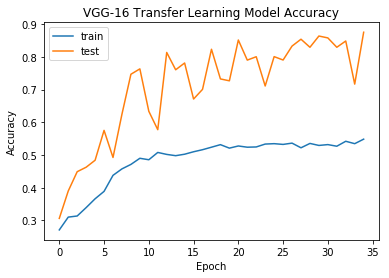

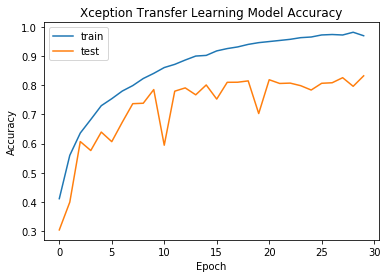

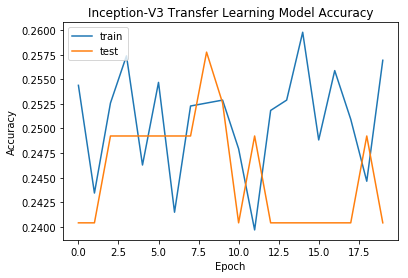

In [36]:
# Visualize VGG-16 Accuracy Score 
plt.plot(vgg16_history.history['acc'])
plt.plot(vgg16_history.history['val_acc'])
plt.title('VGG-16 Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualize Xception Accuracy Score 
plt.plot(xception_history.history['acc'])
plt.plot(xception_history.history['val_acc'])
plt.title('Xception Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Visualize Inception Accuracy Score 
plt.plot(inception_history.history['acc'])
plt.plot(inception_history.history['val_acc'])
plt.title('Inception-V3 Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


From the above charts, VGG-16 reached highest accuracy at about 35 epochs, xception reached at about 4, while inception-v3 did not have any additional improvement from 0.25 after epoch 1. 

***Compare Model Loss Among Three Transfer Learning Models***

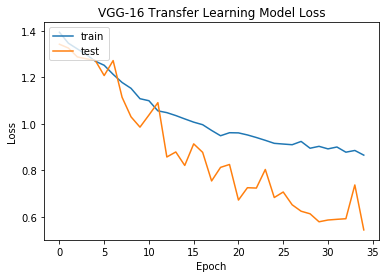

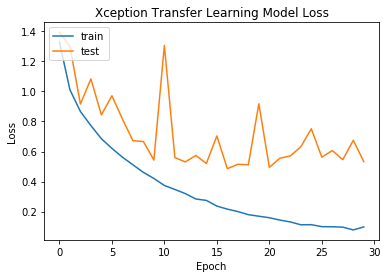

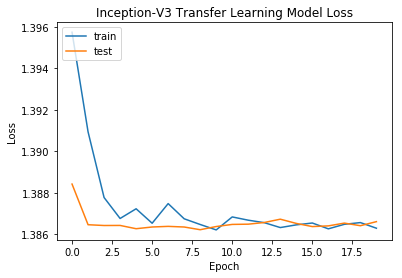

In [37]:
#Visualize VGG-16 Model Loss
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('VGG-16 Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Visualize Xception Model Loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('Xception Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Visualize Inception-V3 Model Loss
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Inception-V3 Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()